# Interpretation of Shapley values

In this chapter you'll learn:

- correct interpretation of Shapley values
- pitfalls for interpretation
- interpretation for many special cases
-


TODO: Look at examples here: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#linear_regression


## Shapley values for linear models


In [131]:
import shap
from sklearn.linear_model import LinearRegression
X,y = shap.datasets.california(n_points=3000)
background = shap.utils.sample(X, 2000)
model = LinearRegression()
model.fit(X, y)

LinearRegression()

Alright, now we have a linear regression model.
Let's first inspect the coefficients and then compare it with the corresponding Shapley values.

In [132]:
import pandas as pd
coefs = pd.DataFrame({"feature": X.columns.values, "value": model.coef_})
print(coefs)

      feature     value
0      MedInc  0.457325
1    HouseAge  0.009440
2    AveRooms -0.140501
3   AveBedrms  1.105387
4  Population  0.000005
5    AveOccup -0.003361
6    Latitude -0.418640
7   Longitude -0.437567


In [133]:
explainer = shap.Explainer(model.predict, background)
shap_values = explainer(X)

Exact explainer: 3001it [00:10, 18.78it/s]                                                   


Alright, now let's plot the feature "MedInc" against its shapley values.

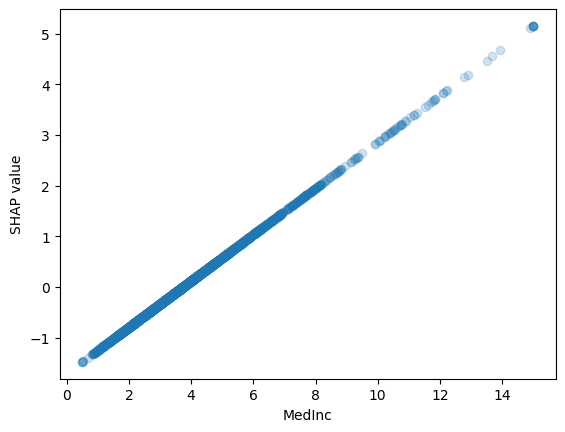

In [134]:
import matplotlib.pyplot as plt
# select one feature for plotting SHAP values
feature_name = 'MedInc'
feature_idx = X.columns.get_loc(feature_name)

# plot SHAP values against feature values
plt.scatter(X[feature_name], shap_values.values[:, feature_idx], alpha=0.2)
plt.xlabel(feature_name)
plt.ylabel('SHAP value')
plt.show()

So we can see that the Shapley value increases linearly with each increase in the feature. And this increase is exactly the same as the slope in 

In [135]:
coefs.value[feature_idx]

0.45732460121985236

In [136]:
model.intercept_

-37.81505214409206

In [137]:
x_range

array([ 0.4999, 15.0001])

We know that in linear regression models, $\phi_{ji}(\hat{f}) = \beta_j x_j - E(\beta_jX_j) = \beta_j (x_j - E(X_j))$
Let's confirm that this is correct:

In [138]:
X[feature_name].mean()

3.8714374666666664

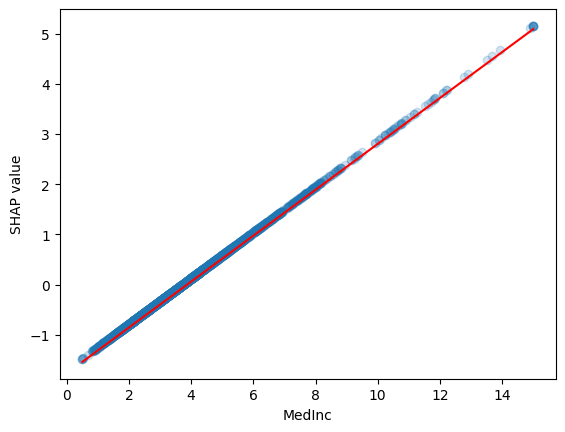

In [139]:
import numpy as np
# plot SHAP values against feature values
plt.scatter(X[feature_name], shap_values.values[:, feature_idx], alpha=0.2)
plt.xlabel(feature_name)
plt.ylabel('SHAP value')

x_range = np.array([X[feature_name].min(), X[feature_name].max()])

plt.plot(x_range, coefs.value[feature_idx] * (x_range - X[feature_name].mean()), color='red')

plt.show()

Looking good, and within an estimation error.

This gives us a first amount of trust in the method.

So we know that when

- the model is additive
- the effects are linear

then the Shapley values are the model coefficient multiplied with the actual feature value minus some constant.
This product is also called the feature effect for an instance.
Because the coefficient alone couldn't tell us how important a feature was for a particular instance. Because it also depends on the actual feature value: if it is large, in absolute terms, then the contribution to the outcome will be much larger than when the value is near zero.
The constant simply adjusts the values towards the mean effect, so that the plot is centered around the *expected feature effect*.

## Shapley values for additive models

In this next step, we allow the relation between a feature and the target to be non-linear.
We don't, however, allow interactions between the features.
Additive models with non-linear base functions are perfectly modeled with so-called generalized additive models, also called GAMs.


A GAM models y in the following way:

$$\hat{f}(x) = \beta_0 + \beta_1 f_1(x_1) + \ldots + f_p(x_p)$$

The difference to the simple linear model is that we allow the functions $f_j$. If these are the identity function for all features, namely $f_j(x_j) = x_j$, then we again come out with the linear model.
So linear regression models are special cases of GAMs.

But with GAMs, we can now have arbitrary functions for the features.
A popular choice are spline functions which allow for rather flexible shapes of functions that are still smooth and have a gradient.

Educationally, to understand Shapley values, they are perfect, because they allow us to study what happens with non-linear functions, but without interactions.
Because only with interactions will the interpretation become trickier.

So we go back to the same example and fit a GAM instead of a linear regression model.

For this we rely on the interpret Python library. YOu can install it with:

In [142]:
!pip install interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 7.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:008.3 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 7.1 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 3.6 MB/s eta 0:00:003.6 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 7.0 MB/s eta 0:00:00m eta 0:00:010:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 7.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 6.7 MB/s eta 0:00:007.3 MB/s eta 0:00:01
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Using cached scikit_image-0.19.3-cp310-cp310-macosx_12_0_arm64.whl (12.5 MB)
  Using cached multiprocess-0.70.14-py310-none-any.whl (134 kB)
  Using cached itsdangerous-2.1.2-py3-none-any.whl (15 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 6.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 6.9 MB/s eta 0:00:007.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.9 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 7.0 MB/s eta 0:00:00m eta 0:00:010:00:01
  Created wheel for gevent: filename=gevent-22.10.2-cp310-cp310-macosx_12_0_arm64.whl size=1782960 sha256=3c64ebadd552e2f5364a24cb67913491efa55f8726bb158762eb1c2265243428
  Stored in directory: /Users/chris/Library/Caches/pip/wheels/17/de/c5/51b1e40d3d86a601c822e0cec04bfcdd91e56742b4d51e5408
Successfully built gevent
  DEPRECATION: greenlet is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found a

Then we train the model:

TODO: Rewrite that code

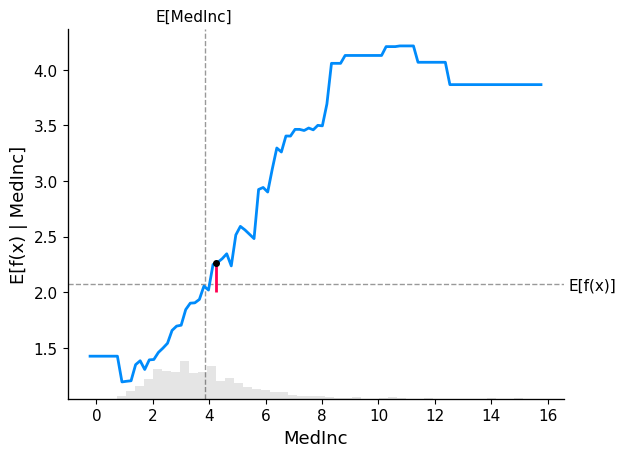

In [146]:
import interpret.glassbox
model_ebm = interpret.glassbox.ExplainableBoostingRegressor(interactions=0)
model_ebm.fit(X, y)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, background)
shap_values_ebm = explainer_ebm(X)

sample_ind = 10

# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    feature_name, model_ebm.predict, background, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:]
)


## Shapley values and feature interactions


## How to interpret the axioms

## Do's and Dont's for interpretation

### Don't extrapolate 

### Do Consider The Background Data

### Don't Overinterpret an Overfitted Model

- TODO: replicate overfitted model here from pitfalls paper as a teaching lesson
-
-

## Summary for Interpretation

- Features that don't contribute to the model get a contribution of zero
- 